<a href="https://colab.research.google.com/github/LordRelentless/NGFTSimulations/blob/main/5_3_1_Simulation_Informational_Curvature_in_Qubit_Systems_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
using Pkg
Pkg.add("Yao")          # Quantum simulation engine
Pkg.add("Plots")        # Visualization
Pkg.add("Random")
Pkg.add("StatsBase")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed TupleTools ──────────────── v1.6.0
   Installed YaoAPI ──────────────────── v0.4.8
   Installed SymEngine_jll ───────────── v0.12.0+0
   Installed YaoPlots ────────────────── v0.9.4
   Installed BatchedRoutines ─────────── v0.2.2
   Installed BitBasis ────────────────── v0.9.10
   Installed Rsvg ────────────────────── v1.0.0
   Installed TreeWidthSolver ─────────── v0.3.5
   Installed ArnoldiMethod ───────────── v0.4.0
   Installed YaoToEinsum ─────────────── v0.2.5
   Installed LegibleLambdas ──────────── v0.3.0
   Installed VectorInterface ─────────── v0.5.0
   Installed Graphics ────────────────── v1.1.3
   Installed KrylovKit ───────────────── v0.9.5
   Installed Graphs ──────────────────── v1.13.0
   Installed MPC_jll ─────────────────── v1.3.1+0
   Installed MLStyle ─────────────────── v0.4.17
   Installed YaoSym ──────────────────── v0.6.9
   Installed YaoBlocks ────────────

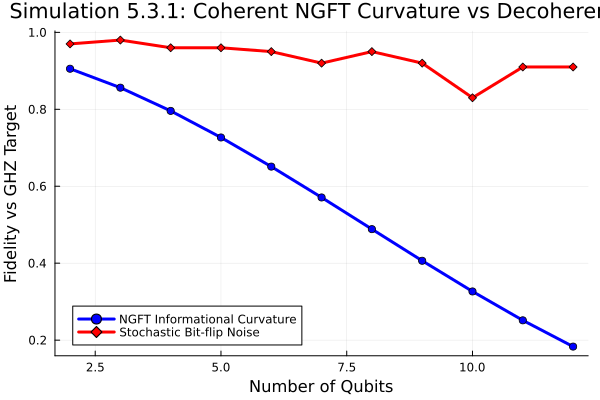

In [7]:
using Yao
using Plots
using Random
using Statistics

# === Simulation Parameters ===
max_qubits = 12                 # Max number of qubits
repeats = 100                   # Number of trials per size
curvature_strength = 0.5        # Phase shift strength for NGFT curvature
decoherence_prob = 0.01         # Flip probability for decoherence model

# === GHZ Circuit Generator ===
function ghz_circuit(n::Int)
    return chain(n, [
        put(n, 1 => H),                               # Hadamard on qubit 1
        chain([control(i, i+1 => X) for i in 1:n-1]...)  # CNOT chain
    ])
end

# === Apply Informational Curvature as Coherent Phase Shifts ===
function apply_curvature(qreg::AbstractRegister, strength::Float64)
    n = nqubits(qreg)
    phases = [strength * (i^2) / n^2 for i in 1:n]
    op = chain([put(n, i => rot(Z, phases[i])) for i in 1:n]...)
    return apply!(qreg, op)
end

# === Apply Stochastic Decoherence (Bit-flip noise) ===
function apply_decoherence(qreg::AbstractRegister, prob::Float64)
    n = nqubits(qreg)
    noisy = deepcopy(qreg)
    for i in 1:n
        if rand() < prob
            noisy = apply!(noisy, put(n, i => X))
        end
    end
    return noisy
end

# === Fidelity Function ===
function fidelity(q₁::AbstractRegister, q₂::AbstractRegister)
    ψ₁ = statevec(q₁)
    ψ₂ = statevec(q₂)
    return abs(dot(ψ₁, ψ₂))^2
end

# === Main Experiment ===
function run_experiment()
    sizes = 2:max_qubits
    curved_fid = Float64[]
    noisy_fid = Float64[]

    for n in sizes
        fid_curve, fid_noise = Float64[], Float64[]

        for _ in 1:repeats
            reg_clean = zero_state(n)
            circuit = ghz_circuit(n)

            ψ_target = apply!(deepcopy(reg_clean), circuit)

            # NGFT Informational Curvature
            ψ_curved = apply_curvature(apply!(deepcopy(reg_clean), circuit), curvature_strength)

            # Standard Noise
            ψ_noisy = apply_decoherence(apply!(deepcopy(reg_clean), circuit), decoherence_prob)

            push!(fid_curve, fidelity(ψ_target, ψ_curved))
            push!(fid_noise, fidelity(ψ_target, ψ_noisy))
        end

        push!(curved_fid, mean(fid_curve))
        push!(noisy_fid, mean(fid_noise))
    end

    return sizes, curved_fid, noisy_fid
end

# === Run and Plot Results ===
sizes, curved, noisy = run_experiment()

plot(sizes, curved, label = "NGFT Informational Curvature", lw = 3, color = :blue, marker = :circle)
plot!(sizes, noisy, label = "Stochastic Bit-flip Noise", lw = 3, color = :red, marker = :diamond)
xlabel!("Number of Qubits")
ylabel!("Fidelity vs GHZ Target")
title!("Simulation 5.3.1: Coherent NGFT Curvature vs Decoherence")